In [1]:
# Load packages we need
import sys
import os
import datetime
import random
import glob
import shutil
import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import tensorflow as tf

# we'll use keras for neural networks
import tensorflow.keras as keras
from tensorflow.keras.datasets import fashion_mnist

# import layers we will use
from tensorflow.keras import layers
#.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate, Dropout
from tensorflow.keras import Model

# import callbacks we will use
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Load the TensorBoard notebook extension
%load_ext tensorboard

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
plt.rcParams.update({'font.size': 18})

# Let's check our software versions
print('### Python version: ' + sys.version)
print('### Numpy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

### Python version: 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) 
[GCC 7.5.0]
### Numpy version: 1.19.4
### Scikit-learn version: 0.23.2
### Tensorflow version: 2.3.1
------------


### Handle Directories for Split ###

In [2]:
# Get directories for different sets of images
data_path = '/home/smarkelon/aml/ships/data/'
path = '/home/smarkelon/aml/ships/'
train_path = path + 'train'
test_path = path + 'test'
validation_path = path + 'validation'

try:
    os.mkdir(train_path)
except:
    pass

try:
    os.mkdir(test_path)
except:
    pass

"""
try:
    os.mkdir(validation_path)
except:
    pass
"""

data_dirs = [train_path,test_path]

In [3]:

# Create smaller training, testing, and validation sets from original training data
import shutil
import random

# clean out directories first just in case
for d in data_dirs:
    del_files = os.listdir(d)
    for dlf in del_files:
        os.remove(d+"/"+dlf)

train_size = 10000
test_size = 2000
validation_size = 0

files = os.listdir(data_path)
random.shuffle(files)

# Create training set
for f in files[:train_size]:
    shutil.copy(data_path + f, train_path)

# Create test set
for f in files[train_size:train_size+test_size]:
    shutil.copy(data_path + f, test_path)

"""
# Create validation set
for f in files[train_size+test_size:train_size+test_size+validation_size]:
    shutil.copy(path + f, validation_path)
"""

'\n# Create validation set\nfor f in files[train_size+test_size:train_size+test_size+validation_size]:\n    shutil.copy(path + f, validation_path)\n'

In [4]:
# Look at data
train_names = os.listdir(train_path)
print(train_names[:10])

['80fae4297.jpg', 'f163ce3dc.jpg', 'fd4db3303.jpg', '767ceb9bb.jpg', '57165b9e4.jpg', '2a2cb243a.jpg', '6b8fc8fa4.jpg', '7dca4d8cb.jpg', '37e689f2b.jpg', 'd980b7ca5.jpg']


In [5]:
print('total training images:', len(os.listdir(train_path)))

total training images: 10000


In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

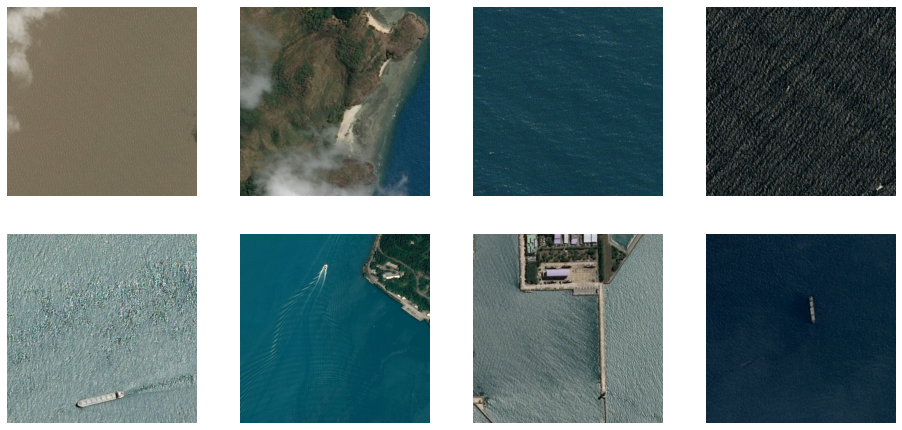

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_set = [os.path.join(train_path, fname) 
                for fname in train_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_set):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
# Get labels from CSV file
df=pd.read_csv('/home/smarkelon/aml/ships/ship_data_bc_proc.csv',dtype=str)
df

,ImageId,ShipPresent
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,0001b1832.jpg,0
...,...,...
192551,fffedbb6b.jpg,0
192552,ffff2aa57.jpg,0
192553,ffff6e525.jpg,0
192554,ffffc50b4.jpg,0


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)

# Generate training dataset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col='ImageId',
    y_col='ShipPresent',
#     subset='training',
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

# Generate testing dataset
test_generator = test_datagen.flow_from_dataframe(
     dataframe=df,
     directory=test_path,
     x_col='ImageId',
     y_col='ShipPresent',
     #subset='testing',
     target_size=(150, 150),  # All images will be resized to 150x150
     batch_size=20,
     # Since we use binary_crossentropy loss, we need binary labels
     class_mode='binary')

"""
# Generate validation dataset
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df,
    directory=validation_path,
    x_col='ImageId',
    y_col='ShipPresent',
#     subset='validation',
    target_size=(256, 256),  # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')
"""

/apps/tensorflow/2.3.1/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 182556 invalid image filename(s) in x_col="ImageId". These filename(s) will be ignored.
  warnings.warn(


Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


/apps/tensorflow/2.3.1/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 190556 invalid image filename(s) in x_col="ImageId". These filename(s) will be ignored.
  warnings.warn(


"\n# Generate validation dataset\nval_generator = val_datagen.flow_from_dataframe(\n    dataframe=df,\n    directory=validation_path,\n    x_col='ImageId',\n    y_col='ShipPresent',\n#     subset='validation',\n    target_size=(256, 256),  # All images will be resized to 150x150\n    batch_size=20,\n    # Since we use binary_crossentropy loss, we need binary labels\n    class_mode='binary')\n"

In [28]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [29]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# No droput first
# Add dropout rate
#x = layers.Dropout(0.25)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [30]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 64)       

In [31]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [32]:
import math

# Set up model checkpoint to save best model
best_model_file = 'mymodel.h5'
checkpoint_cb = ModelCheckpoint(best_model_file, monitor='val_acc', save_best_only=True, mode='max')


train_size = 10000
test_size = 2000
batch_size = 20

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

spe = compute_steps_per_epoch(train_size)
vs = compute_steps_per_epoch(test_size)

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=spe,
      epochs=15,
      validation_data=test_generator,
      validation_steps=vs,
      verbose=2, callbacks=[checkpoint_cb])

Epoch 1/15
500/500 - 96s - loss: 0.5229 - acc: 0.7778 - val_loss: 0.4097 - val_acc: 0.8180
Epoch 2/15
500/500 - 96s - loss: 0.4071 - acc: 0.8355 - val_loss: 0.3277 - val_acc: 0.8665
Epoch 3/15
500/500 - 96s - loss: 0.3458 - acc: 0.8724 - val_loss: 0.3072 - val_acc: 0.8805
Epoch 4/15
500/500 - 96s - loss: 0.3151 - acc: 0.8900 - val_loss: 0.2823 - val_acc: 0.8845
Epoch 5/15
500/500 - 96s - loss: 0.2878 - acc: 0.9017 - val_loss: 0.2923 - val_acc: 0.8995
Epoch 6/15
500/500 - 95s - loss: 0.2579 - acc: 0.9131 - val_loss: 0.3267 - val_acc: 0.8865
Epoch 7/15
500/500 - 96s - loss: 0.2388 - acc: 0.9198 - val_loss: 0.3264 - val_acc: 0.8970
Epoch 8/15
500/500 - 96s - loss: 0.2129 - acc: 0.9315 - val_loss: 0.3686 - val_acc: 0.8915
Epoch 9/15
500/500 - 95s - loss: 0.1931 - acc: 0.9390 - val_loss: 0.4221 - val_acc: 0.8945
Epoch 10/15
500/500 - 95s - loss: 0.1739 - acc: 0.9453 - val_loss: 0.5614 - val_acc: 0.8850
Epoch 11/15
500/500 - 95s - loss: 0.1564 - acc: 0.9529 - val_loss: 0.5203 - val_acc: 0.89

<ipython-input-34-035f6330089f>:40: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


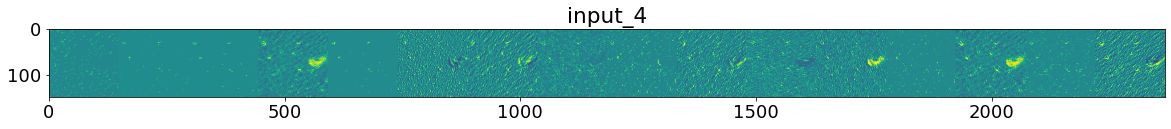

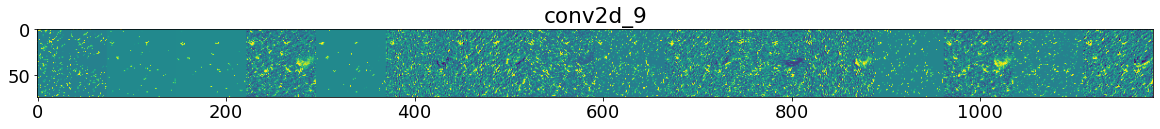

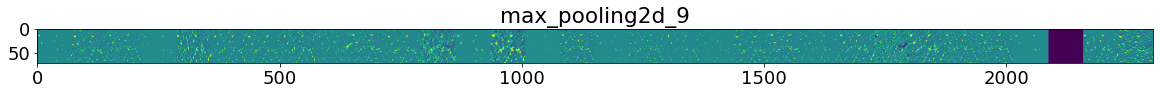

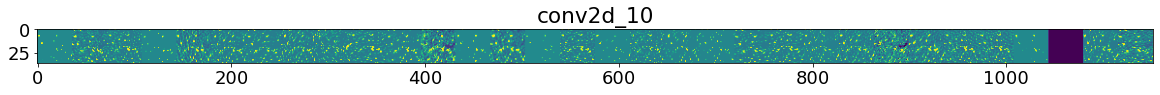

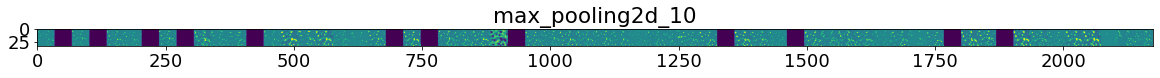

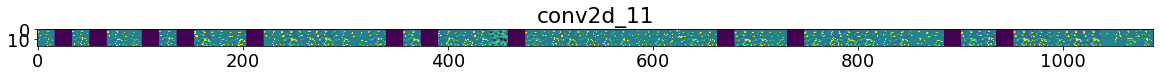

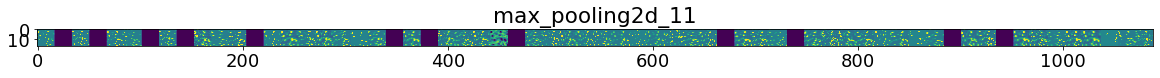

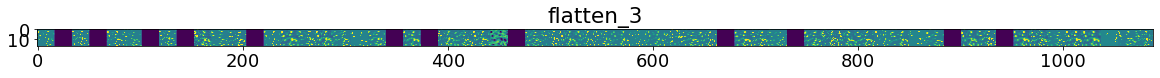

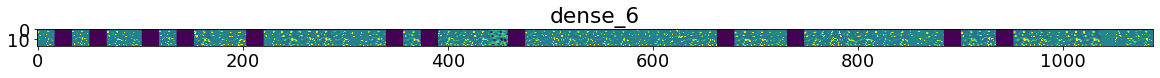

In [34]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
img_files = [os.path.join(train_path, f) for f in train_names]
img_path = random.choice(img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

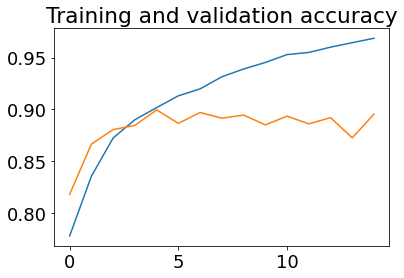

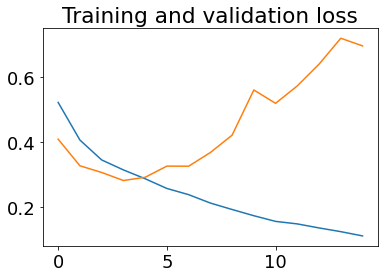

In [35]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [52]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [53]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add dropout rate
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [54]:
model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 64)      

In [55]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [56]:
import math

# Set up model checkpoint to save best model
best_model_file2 = 'mymodel2.h5'
checkpoint_cb = ModelCheckpoint(best_model_file2, monitor='val_acc', save_best_only=True, mode='max')


train_size = 10000
test_size = 2000
batch_size = 20

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

spe = compute_steps_per_epoch(train_size)
vs = compute_steps_per_epoch(test_size)

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=spe,
      epochs=15,
      validation_data=test_generator,
      validation_steps=vs,
      verbose=2, callbacks=[checkpoint_cb])

Epoch 1/15
500/500 - 93s - loss: 0.5055 - acc: 0.7785 - val_loss: 0.4341 - val_acc: 0.7895
Epoch 2/15
500/500 - 93s - loss: 0.4470 - acc: 0.7985 - val_loss: 0.4744 - val_acc: 0.8020
Epoch 3/15
500/500 - 93s - loss: 0.4305 - acc: 0.8228 - val_loss: 0.4262 - val_acc: 0.8170
Epoch 4/15
500/500 - 94s - loss: 0.4136 - acc: 0.8403 - val_loss: 0.3654 - val_acc: 0.8690
Epoch 5/15
500/500 - 93s - loss: 0.3976 - acc: 0.8553 - val_loss: 0.4265 - val_acc: 0.8705
Epoch 6/15
500/500 - 93s - loss: 0.3880 - acc: 0.8635 - val_loss: 0.3263 - val_acc: 0.8715
Epoch 7/15
500/500 - 92s - loss: 0.3729 - acc: 0.8738 - val_loss: 0.4021 - val_acc: 0.8595
Epoch 8/15
500/500 - 93s - loss: 0.3480 - acc: 0.8828 - val_loss: 0.3173 - val_acc: 0.8945
Epoch 9/15
500/500 - 93s - loss: 0.3363 - acc: 0.8896 - val_loss: 0.3288 - val_acc: 0.8815
Epoch 10/15
500/500 - 92s - loss: 0.3352 - acc: 0.8949 - val_loss: 0.3132 - val_acc: 0.8820
Epoch 11/15
500/500 - 92s - loss: 0.3028 - acc: 0.9057 - val_loss: 0.3721 - val_acc: 0.88

Text(0.5, 1.0, 'Training and validation loss')

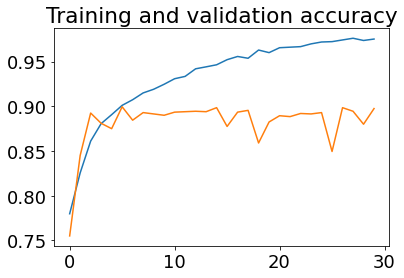

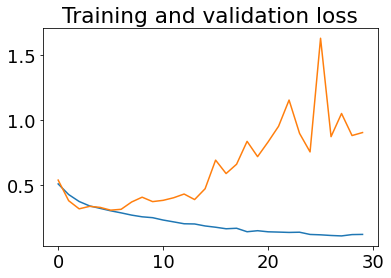

In [46]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')